# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

*include contributors names here (such as Name1, Name2, ...)*

## General Setup

In [138]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

In [139]:
# Load data
data = pd.read_csv("the_office.csv")
data_explore = data.copy()

In [148]:
with open('MLP_cold_opens.txt', 'r') as file:
    new_data = file.read().replace('\n', '')

x = new_data.split(")")
hots = []
for i in range(len(x)):
    if x[i][0:4] == 'None':
        hots.append(x[i][7:-1])
    elif x[i][0:8] == 'Season 1' and x[i][8:12] == 'None':
        hots.append(x[i][14:])
    elif x[i][0:6] == 'Season' and x[i][8:12] == 'None':
        hots.append(x[i][15:-1])

hots_df = pd.DataFrame (hots, columns = ['episode_name'])
hots_df['cold_open'] = np.zeros(12).astype(int)
hots_df = hots_df.replace(to_replace = 'Weight Loss', value = 'Weight Loss (Parts 1&2)')
data_ = pd.merge(data, hots_df, on='episode_name', how='left')
data_['cold_open'] = data_['cold_open'].fillna(1)

data_.loc[data_['cold_open'] == 1]

data = data_
data_explore = data.copy()

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

In [149]:
print ("Columns in the df are:")
print (data_explore.columns.tolist(), "\n")

dup_num = pd.DataFrame(data_explore).duplicated().sum()
print("There are {} duplicated values in the data".format(dup_num))

na_num = data_explore.isna().sum().sum()
print(f"There are {na_num} Na values in the data")

data_explore.describe()


Columns in the df are:
['season', 'episode', 'episode_name', 'director', 'writer', 'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'cold_open'] 

There are 0 duplicated values in the data
There are 0 Na values in the data


,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,cold_open
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548,0.935484
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407,0.246333
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000,0.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000,1.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000,1.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000,1.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000,1.000000


Measuring the correlation between the current numerical variables:

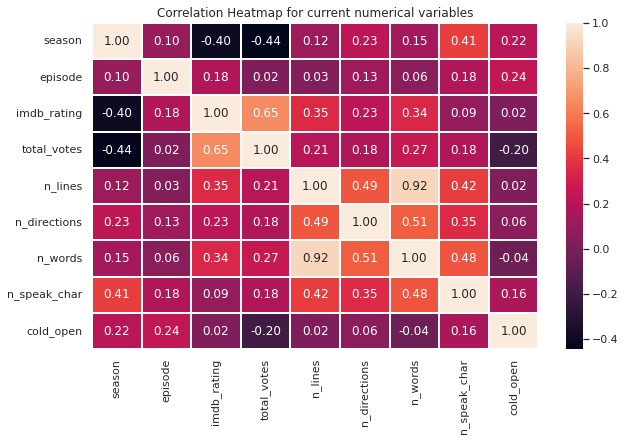

In [150]:
sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(data_explore.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap for current numerical variables")
plt.show()

We will first drop the episode name and episode number features because they are not relevant to the model.

In [151]:
data_explore = data_explore.drop("episode_name", axis=1)
data_explore = data_explore.drop("episode", axis=1)

print (data_explore.columns.tolist())

['season', 'director', 'writer', 'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'cold_open']


Next, we will use the variable "air_date" to create two new features: Categorical variable "calendar_season", being the season (autumn, winter, spring, summer) when the episode was aired; and (numerical variable?) "air_month" being the month the episode aired. After this we drop "air_date".

In [152]:
# data['air_date'] = pd.to_datetime(data['air_date'])

# convert the 'dates' column to datetime format
data_explore['air_date'] = pd.to_datetime(data_explore['air_date'])

# create a new categorical column 'calendar_season' by assigning a category "winter", 
# "spring", "summer", "autumn" depending on the air-month.
data_explore['calendar_season'] = pd.cut(
    data_explore['air_date'].dt.month, 
    [0, 3, 6, 9, 12], 
    labels=['winter', 'spring', 'summer', 'autumn']
)

# convert calender season to string column rather than categorical column.
data_explore['calendar_season'] = data_explore['calendar_season'].astype(str)

# Create month column.
data_explore['month'] = data_explore['air_date'].dt.month

data_explore.head(5)


,season,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars,cold_open,calendar_season,month
0,1,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,0.0,winter,3
1,1,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,0.0,winter,3
2,1,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,spring,4
3,1,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,spring,4
4,1,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,0.0,spring,4


In [153]:
data_explore = data_explore.drop("air_date", axis=1)
data_explore.head(5)

,season,director,writer,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,main_chars,cold_open,calendar_season,month
0,1,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,0.0,winter,3
1,1,Ken Kwapis,B.J. Novak,8.3,3566,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,0.0,winter,3
2,1,Ken Whittingham,Paul Lieberstein,7.9,2983,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,spring,4
3,1,Bryan Gordon,Michael Schur,8.1,2886,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,spring,4
4,1,Greg Daniels,Greg Daniels,8.4,3179,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,0.0,spring,4


We now write a one hot encoder function to assign a binary attribute per category for the Categorical variables ("director, "writer", "calendar_season" and "main_chars"):

In [154]:
def OneHot_encoder(df, cat_variable):
    oneHot_df = df.copy()
    variable_initials = ''.join([word[0] for word in cat_variable.split("_")])

    
    unique_chars = set(';'.join(oneHot_df[cat_variable]).split(';'))

    # Create binary attributes for each unique character
    for char in unique_chars:
        oneHot_df[variable_initials+"_"+char] = oneHot_df[cat_variable].apply(lambda x: 1 if char in x else 0)
    
    
    # Drop the original main_chars column
    oneHot_df = oneHot_df.drop(columns=[cat_variable])
    
    return oneHot_df


cat_variables = ['director', 'writer', 'main_chars', 'calendar_season']

for cat_variable in cat_variables:
    data_explore = OneHot_encoder(data_explore, cat_variable)
    

data_explore.head(5)

    

,season,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,cold_open,month,d_Bryan Cranston,...,mc_Toby,mc_Meredith,mc_Phyllis,mc_Kevin,mc_Kelly,mc_Dwight,cs_summer,cs_spring,cs_autumn,cs_winter
0,1,7.6,3706,229,27,2757,15,0.0,3,0,...,0,0,1,1,0,1,0,0,0,1
1,1,8.3,3566,203,20,2808,12,0.0,3,0,...,1,0,0,1,1,1,0,0,0,1
2,1,7.9,2983,244,21,2769,13,0.0,4,0,...,0,1,0,1,0,1,0,1,0,0
3,1,8.1,2886,243,24,2939,14,0.0,4,0,...,1,1,1,1,0,1,0,1,0,0
4,1,8.4,3179,230,49,2437,18,0.0,4,0,...,0,0,1,1,0,1,0,1,0,0


By inspection we realised that there are some repeated directors where in some data entries the name of the director is spelled wrong. The specific cases were:

 - Charles McDougall (correct name) and Charles McDougal
 - Claire Scanlon (correct name) and Claire Scanlong 
 - Greg Daniels (correct name) and Greg Daneils
 - Ken Whittingham (correct name) and Ken Wittingham 
 - Paul Lieberstein (correct name) and Paul Lieerstein
 
Thus we now write code to remove columns with the wrong name, where we will put a 1 in the correct name column if the incorrect one had a 1 and the correct one didn't.

In [155]:
correct_names = ['d_Charles McDougall','d_Claire Scanlon','d_Greg Daniels', 'd_Ken Whittingham', 'd_Paul Lieberstein']
wrong_names = ['d_Charles McDougal','d_Claire Scanlong','d_Greg Daneils', 'd_Ken Wittingham', 'd_Paul Lieerstein']

for i, correct_name in enumerate(correct_names):
    data_explore.loc[data_explore[wrong_names[i]] == 1, correct_name] = 1
    data_explore = data_explore.drop(wrong_names[i], axis=1)
    
data_explore.head(5)

,season,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,cold_open,month,d_Bryan Cranston,...,mc_Toby,mc_Meredith,mc_Phyllis,mc_Kevin,mc_Kelly,mc_Dwight,cs_summer,cs_spring,cs_autumn,cs_winter
0,1,7.6,3706,229,27,2757,15,0.0,3,0,...,0,0,1,1,0,1,0,0,0,1
1,1,8.3,3566,203,20,2808,12,0.0,3,0,...,1,0,0,1,1,1,0,0,0,1
2,1,7.9,2983,244,21,2769,13,0.0,4,0,...,0,1,0,1,0,1,0,1,0,0
3,1,8.1,2886,243,24,2939,14,0.0,4,0,...,1,1,1,1,0,1,0,1,0,0
4,1,8.4,3179,230,49,2437,18,0.0,4,0,...,0,0,1,1,0,1,0,1,0,0


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from